# Variatioanal Autoencoder on MNIST Data 

<img src="vae_model.png">

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras.datasets import mnist 
from keras.layers import Input, Dense, Lambda 
from keras.models import Model
from keras import backend as K 
from keras import objectives 
from scipy.stats import norm 
from keras.utils import plot_model

/home/gomesc/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the Data 

In [2]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()
#noramalise it 
x_train, x_test = x_train.astype('float32')/255, x_test.astype('float32')/255
#flatten the tensor 
x_train, x_test = x_train.reshape(x_train.shape[0],-1), x_test.reshape(x_test.shape[0],-1)
print(x_train.shape,x_test.shape)

11493376/11490434 [==============================] - 2s 0us/step
(60000, 784) (10000, 784)


## Parameters 

In [3]:
batch_size, n_epoch = 100, 20
n_hidden, latent_dim = 256, 2

## Encoder 

In [4]:
model_input = Input(shape=(x_train.shape[1:]),name='Input_Layer')
input_encoded = Dense(n_hidden, activation = 'relu',name='first_encdoing_layer')(model_input)
input_encoded = Dense(n_hidden//2, activation = 'relu',name = 'second_endcoding_layer')(input_encoded)
z_mean = Dense(latent_dim,name='Z_Mean')(input_encoded)
z_log_var = Dense(latent_dim,name='Z_variance')(input_encoded)

Instructions for updating:
Colocations handled automatically by placer.


## Re-parameterization Trick 

In [5]:
def sample_z(args):
    z_mean, z_log_var = args 
    epsilon = K.random_normal(shape = (batch_size, latent_dim),mean=0, stddev = 1)
    return z_mean + K.exp(z_log_var/2) * epsilon
#look up keras.layer.Lambda, its worth a look for comprhending the dynamics furthermore 
z = Lambda(sample_z,output_shape=(latent_dim,),name = 'Z')([z_mean,z_log_var])

## Decoder

In [6]:
decoder = Dense(n_hidden//2,activation = "relu",name='first_decoding_layer')(z)
decoder = Dense(n_hidden,activation = "relu",name='second_decoding_layer')(decoder)
model_output = Dense(x_train.shape[1], activation='sigmoid',name = 'Output_Layer')(decoder)

## Define Loss Function and Compile the Model 

In [7]:
# loss
reconstruction_loss = objectives.binary_crossentropy(model_input, model_output) * x_train.shape[1]
kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 2, axis = -1)
vae_loss = reconstruction_loss + kl_loss


# try -2 instead of 1 

# build model
vae = Model(model_input, model_output)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
#plot_model(vae, to_file='vae_model.png', show_shapes=True) uncomment when using on colab 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
first_encdoing_layer (Dense)    (None, 256)          200960      Input_Layer[0][0]                
__________________________________________________________________________________________________
second_endcoding_layer (Dense)  (None, 128)          32896       first_encdoing_layer[0][0]       
__________________________________________________________________________________________________
Z_Mean (Dense)                  (None, 2)            258         second_endcoding_layer[0][0]     
__________________________________________________________________________________________________
Z_variance

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Train the Model 

In [9]:
vae.fit(x_train,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_test, None), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 118us/step - loss: 187.5524 - val_loss: 167.1539
Epoch 2/20
60000/60000 [==============================] - 6s 100us/step - loss: 163.4442 - val_loss: 160.5622
Epoch 3/20
60000/60000 [==============================] - 6s 97us/step - loss: 158.3469 - val_loss: 156.4848
Epoch 4/20
60000/60000 [==============================] - 6s 98us/step - loss: 155.1558 - val_loss: 154.0473
Epoch 5/20
60000/60000 [==============================] - 6s 98us/step - loss: 152.8523 - val_loss: 152.5016
Epoch 6/20
60000/60000 [==============================] - 6s 99us/step - loss: 150.9692 - val_loss: 150.3930
Epoch 7/20
60000/60000 [==============================] - 6s 99us/step - loss: 149.4467 - val_loss: 149.1854
Epoch 8/20
60000/60000 [==============================] - 6s 99us/step - loss: 148.2388 - val_loss: 148.1926
Epoch 9/20
60000/60000 [====

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     (None, 784)               0         
_________________________________________________________________
first_encdoing_layer (Dense) (None, 256)               200960    
_________________________________________________________________
second_endcoding_layer (Dens (None, 128)               32896     
_________________________________________________________________
Z_Mean (Dense)               (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________
<class 'numpy.ndarray'>


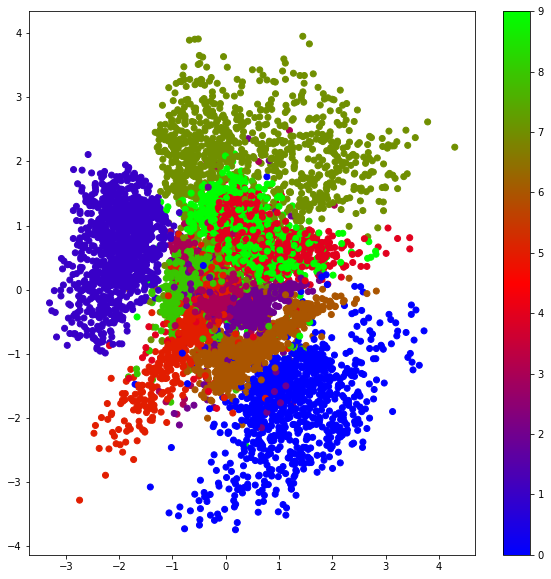

In [10]:
# Plot of the digit classes in the latent space
encoder = Model(model_input, z_mean)
encoder.summary()

x_test_latent =encoder.predict(x_test, batch_size=batch_size)
print(type(x_test_latent))
plt.figure(figsize=(10, 10))
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test,cmap='brg')
plt.colorbar()
plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
first_encdoing_layer (Dense)    (None, 256)          200960      Input_Layer[0][0]                
__________________________________________________________________________________________________
second_endcoding_layer (Dense)  (None, 128)          32896       first_encdoing_layer[0][0]       
__________________________________________________________________________________________________
Z_Mean (Dense)                  (None, 2)            258         second_endcoding_layer[0][0]     
__________________________________________________________________________________________________
Z_variance

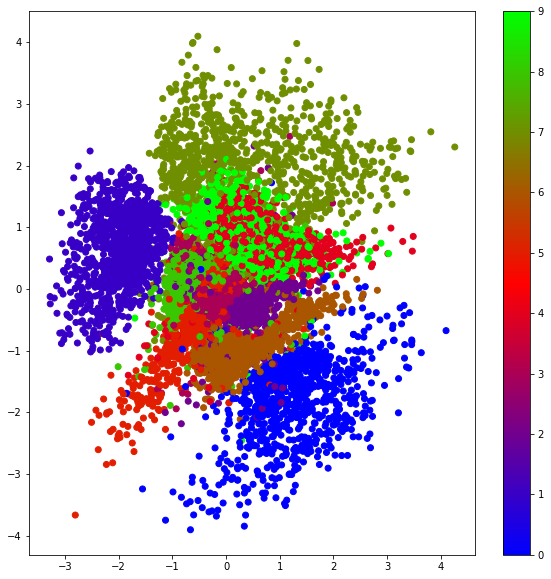

In [11]:
# Plot of the digit classes in the latent space wrapper, not really important just for fun 
encoder = Model(model_input, z)
encoder.summary()

x_test_latent =encoder.predict(x_test, batch_size=batch_size)
print(type(x_test_latent))
plt.figure(figsize=(10, 10))
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], c=y_test,cmap='brg')
plt.colorbar()
plt.show()

In [12]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

AttributeError: 'Tensor' object has no attribute 'predict'